In [24]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, matplotlib.pyplot as plt, pickle
from tqdm import trange
import scipy, pystan as ps
%matplotlib inline
from time import time
from pylab import plot, show, legend
from Geyer_IACT import *

In [2]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

N = 21 
m = 68
p = 10

In [3]:
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_core'
with open(name + '.pkl', 'rb') as f: trace_core = pickle.load(f)
    
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_DL'
with open(name + '.pkl', 'rb') as f: trace_unconstrained = pickle.load(f)

In [4]:
def project(U) :
    m, p = np.shape(U)
    assert p <= m
    A, _, B = np.linalg.svd(U)
    proj = np.zeros(np.shape(U))
    for i in range(p) :
        proj += np.matmul(np.reshape(A[:,i],(m,1)),np.reshape(B[i],(1,p)))
    return proj

In [5]:
Nsamples = np.shape(trace_unconstrained['U'])[0]
projU = np.zeros(np.shape(trace_unconstrained['U']))
projD = np.zeros(np.shape(trace_unconstrained['D']))
for i in range(Nsamples) :
    projU[i] = project(trace_unconstrained['U'][i])
    for n in range(np.shape(trace_unconstrained['D'])[1]) :
        projD[i,n] = trace_unconstrained['D'][i,n]*np.linalg.norm(trace_unconstrained['U'][i], ord=2)**2

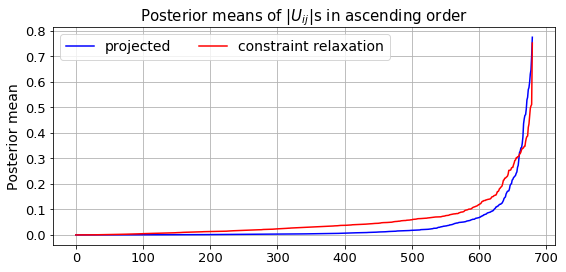

In [19]:
plt.figure(figsize=(9,4))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(np.sort(np.abs(np.mean(projU,0)).flatten()), 'b-', label="projected")
plt.plot(np.sort(np.abs(np.mean(trace_core['U'],0)).flatten()), 'r-', label="constraint relaxation")
plt.legend(ncol=2, fancybox=True, fontsize=14)
plt.grid(True)
plt.ylabel("Posterior mean", fontsize=14)
plt.title(r"Posterior means of $|U_{ij}|$s in ascending order", fontsize=15)
plt.savefig("core_vs_proj.pdf", dpi=2000, bbox_inches='tight')

### Credible intervals:

In [7]:
np.shape(projU)

(10000, 68, 10)

In [8]:
CI_proj_len = 0
CI_core_len = 0

chains = 10

for i in range(m) :
    for j in range(p) :
        for k in range(chains) :
            CI_proj = np.percentile(projU[k*1000:(k+1)*1000,i,j], [2.5,97.5])
            CI_proj_len += CI_proj[1]-CI_proj[0]
            
            CI_core = np.percentile(trace_core['U'][k*1000:(k+1)*1000,i,j], [2.5,97.5])
            CI_core_len += CI_core[1]-CI_core[0]
            
print(CI_core_len/CI_proj_len)

2.450115660806033


In [9]:
CI_proj_len = 0
CI_core_len = 0

for i in range(m) :
    for j in range(p) :
        CI_proj = np.percentile(projU[:,i,j], [2.5,97.5])
        CI_proj_len += CI_proj[1]-CI_proj[0]
            
        CI_core = np.percentile(trace_core['U'][:,i,j], [2.5,97.5])
        CI_core_len += CI_core[1]-CI_core[0]
            
print(CI_core_len/CI_proj_len)

1.7070349895128707


In [27]:
IACT_proj = np.zeros((10,m,p))
IACT_core = np.zeros((10,m,p))
for i in range(m) :
    for j in range(p) :
        for k in range(chains) :
            IACT_proj[k,i,j] = gewer_estimate_IAT(projU[k*1000:(k+1)*1000,i,j])
            IACT_core[k,i,j] = gewer_estimate_IAT(trace_core['U'][k*1000:(k+1)*1000,i,j])

In [32]:
1000/np.max(IACT_proj), 1000/np.max(IACT_core)

(680.628021527954, 614.0839776420702)